## 生成随机数据

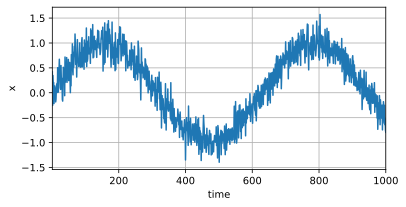

In [102]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [103]:
# 这个是横坐标，就是普通的整数，理解为时间序列
time[10]

tensor(11.)

## 构建样本数据集

$x_t$ 的值取决于 $(x_{t-1}, x_{t-2}, ... x_{t-τ})$

所以，下边的 labels[0] 是 $x_τ$

$features[0] = (x_{τ-1}, x_{τ-2}, x_{τ-3}, x_{0})$

In [104]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [105]:
features.shape, labels.shape

(torch.Size([996, 4]), torch.Size([996, 1]))

features[1] 的最后一个值是 $x_4$

而，labels[0] 的值就是恰好等于 $x_4$

说明就是预测 $x_i$ 的值要使用不包含 $x_i$ 的前几个相邻的值作为特征输入

In [106]:
features[1]

tensor([-0.2525,  0.3457,  0.1176,  0.2046])

In [107]:
labels[0]

tensor([0.2046])

## 创建数据迭代器

In [108]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

这里用到的网络模型与回归问题没有本质的区别，只是数据的构造方式发生了变化，不再是使用 $x_{t}$ 和 $y_{t}$ 的映射关系进行回归，而是使用 $tau$ 个样本来预测 $x_{t}$

In [109]:
features.shape

torch.Size([996, 4])

In [110]:
labels.shape

torch.Size([996, 1])

## 一个简单的网络

In [111]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

## 训练模型

In [112]:
def train(net, train_iter, loss, epochs, lr):
    # trainer 就是 优化器, 优化器里有网络的参数
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()  # 梯度归零
            l = loss(net(X), y)  # 前向传播 and 计算损失
            l.sum().backward()  # 反向传播计算梯度
            trainer.step()  # 更新权重
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.080566
epoch 2, loss: 0.068024
epoch 3, loss: 0.061099
epoch 4, loss: 0.057503
epoch 5, loss: 0.057767


## 预测

仅从这里看，若要预测 $time_i$ 那么就要知道这个时刻的取值，这是属于在已经序列内的情况。

若要预测的 $time_i$ 已经偏离已知序列的最后一个时刻非常远了，那么只能一个一个的往后预测，最终预测到时间点很远的 $time_i$，但是这样，在序列中会不断积累误差，从而越来越偏离真实情况。

In [113]:
features.shape

torch.Size([996, 4])

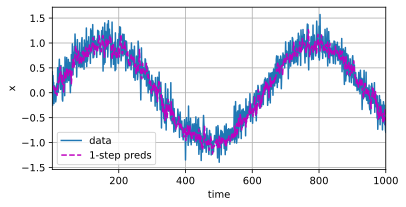

In [114]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

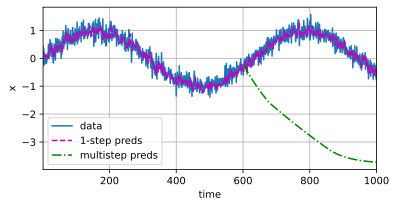

In [115]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

## k 步预测的困难

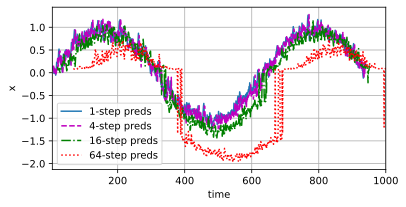

In [116]:
# 会给出从预测 1 步到预测 64 步；在 64 种情况下的预测结果
# 在下方的 steps = (1, 4, 16, 64) 给出的只是需要展示在图上的特殊的几种情况
max_steps = 64
# T - tau - max_steps + 1 => 样本个数
# tau + max_steps => 
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
# x 是纵坐标不是横坐标!!!
# 对于整个 x 序列来说，features 第i号列 确实是从（i）到（i+T-tau-max_steps+1）的时间步
# 但对于 features 的行上来看，从样本的角度来看，每行的第 0 号值都是一个从头开始的时间步
for i in range(tau):
    # 用一种巧妙的方式，构造 T - tau - max_steps + 1 个样本
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    # features[:, i - tau:i] 是一个矩阵，传入所有的样本然后预测
    # 当 i = 0 的时候取的输入就是真是数据种向前看 tau 个数值然后观测出来的值
    # 当 i = 1 的时候，输入的数据中就含有了一个根据真实数据，1 步预测的结果基础上进行的 2 步预测了
    # 当 i 继续增大的时候，在输入数据中就会含有更多的预测数据了，而非都是真实数据了
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

# 在这里看一看 [1, 64] 步预测中的 1， 4， 16， 64 这 4 种步数的预测效果
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))